Parse the profiler output to match up stages between CPU and GPU queries.

In [13]:
import heapq
import os
import re

import pandas as pd
from matplotlib import pyplot as plt

cpu_profile_dirs = ["/opt/data/profiles/dataproc-cpu-sf100",
                    "/opt/data/profiles/dataproc-cpu-sf3k",
                    "/opt/data/profiles/dataproc-cpu-sf5k",
                    "/opt/data/profiles/dataproc-cpu-sf10k"]
gpu_profile_dirs = ["/opt/data/profiles/dataproc-gpu-sf100",
                    "/opt/data/profiles/dataproc-gpu-sf3k",
                    "/opt/data/profiles/dataproc-gpu-sf5k",
                    "/opt/data/profiles/dataproc-gpu-sf10k"]
scale_factors = ["100", "3K", "5K", "10K"]

In [14]:
class Stage:
    def __init__(self, row, whole_stage_codegen_map):
        self.sql_id = row.sqlID
        self.job_id = row.jobID
        self.stage_id = row.stageId
        stage_attempt_id = row.stageAttemptId
        assert stage_attempt_id == 0
        self.stage_duration = row["Stage Duration"]
        self.sql_nodes = str(row["SQL Nodes(IDs)"])

        nodes = self.sql_nodes.split(",")
        cleaned_nodes = [re.sub(r'\(\d+\)$', '', s).strip() for s in nodes]
        if whole_stage_codegen_map is None:
            expanded_nodes = cleaned_nodes
        else:
            expanded_nodes = []
            for n in cleaned_nodes:
                if n in whole_stage_codegen_map:
                    expanded_nodes.extend(whole_stage_codegen_map[n])
                else:
                    expanded_nodes.append(n)
        filtered_nodes = [n for n in expanded_nodes if
                          n != "ColumnarToRow" and
                          n != "GpuShuffleCoalesce" and
                          n != "GpuCoalesceBatches" and
                          n != "GpuColumnarToRow" and
                          n != "GpuRowToColumnar"]
        de_gpu_nodes = [n
                        .replace("GpuShuffledHashJoin", "SortMergeJoin")
                        .replace("GpuColumnar", "")
                        .replace("Gpu", "")
                        for n in filtered_nodes]
        self.canonical_sql_nodes = de_gpu_nodes

    def __str__(self):
        return f"{self.sql_id}, {self.job_id}, {self.stage_id}, {self.stage_duration}, {self.canonical_sql_nodes}"


class CombinedStage:
    def __init__(self, stages):
        self.stages = stages
        self.stage_duration = sum([s.stage_duration for s in stages])
        self.canonical_sql_nodes = [n for s in stages for n in s.canonical_sql_nodes]
        if len(stages) > 1:
            nodes = self.canonical_sql_nodes
            self.canonical_sql_nodes = [nodes[0]]
            for node_index in range(1, len(nodes)):
                n = nodes[node_index]
                if n != "Exchange" or n != nodes[node_index - 1]:
                    self.canonical_sql_nodes.append(nodes[node_index])

    def __str__(self):
        return f"{self.stage_duration}, {self.canonical_sql_nodes}"


def build_whole_stage_codegen_map(profile):
    df = pd.read_csv(f"{profile}/wholestagecodegen_mapping.csv")
    filtered = df[df['Child Node'] != "ColumnarToRow"]
    sql_to_child_nodes = filtered.groupby('SQL Node')['Child Node'].apply(list).to_dict()
    return sql_to_child_nodes


def collect_stages(profile, whole_stage_codegen_map=None):
    df = pd.read_csv(f"{profile}/sql_to_stage_information.csv")
    stages = []
    for _, row in df.iterrows():
        stages.append(Stage(row, whole_stage_codegen_map))
    return stages


def combine_stages(stages):
    combined = []
    # Add single stages first.
    for s in stages:
        combined.append(CombinedStage([s]))
    # Add combined stages.
    for s in stages:
        if s.canonical_sql_nodes[-1] != "Scan parquet":
            for t in stages:
                combined.append(CombinedStage([s, t]))
    return combined


def calculate_match_score(cpu_stage, gpu_stage):
    total_length = len(cpu_stage.canonical_sql_nodes) + len(gpu_stage.canonical_sql_nodes)
    x = list(reversed(cpu_stage.canonical_sql_nodes))
    y = list(reversed(gpu_stage.canonical_sql_nodes))
    matches = 0
    i, j = 0, 0
    while i < len(x) and j < len(y):
        found_match = False

        # Find the earliest match from current indices onwards
        for offset in range(max(len(x) - i, len(y) - j)):
            if i + offset < len(x) and x[i + offset] in y[j:]:
                j_match = y[j:].index(x[i + offset]) + j
                matches += 1
                i += offset + 1
                j = j_match + 1
                found_match = True
                break  # Break after finding the first match

            if j + offset < len(y) and y[j + offset] in x[i:]:
                i_match = x[i:].index(y[j + offset]) + i
                matches += 1
                j += offset + 1
                i = i_match + 1
                found_match = True
                break  # Break after finding the first match

        if not found_match:  # No match found in this iteration, break the loop
            break
    return matches * 2 / total_length


def match_stages(cpu_list, gpu_list):
    matches = []
    for cpu in cpu_list:
        heap = []
        for gpu_index, gpu in enumerate(gpu_list):
            score = calculate_match_score(cpu, gpu)
            heapq.heappush(heap, (-score, gpu_index))
        largest_index = heapq.heappop(heap)[1]
        largest_gpu = gpu_list.pop(largest_index)
        matches.append((cpu, largest_gpu))
    return matches


num_scale_factors = len(scale_factors)
# num_scale_factors = 1
num_cpu_stages = 0
num_gpu_stages = 0
cpu_stage_times = [[] for _ in range(num_scale_factors)]
gpu_stage_times = [[] for _ in range(num_scale_factors)]

for scale_factor in range(num_scale_factors):
    cpu_apps = os.listdir(cpu_profile_dirs[scale_factor])
    cpu_apps.sort()
    gpu_apps = os.listdir(gpu_profile_dirs[scale_factor])
    gpu_apps.sort()
    assert len(cpu_apps) == len(gpu_apps)
    for app in range(len(cpu_apps)):
    # for app in range(1):
        print(
            f"Processing cpu profile {cpu_apps[app]}, gpu profile {gpu_apps[app]}, scale factor {scale_factors[scale_factor]}...")
        whole_stage_codegen_dict = build_whole_stage_codegen_map(f"{cpu_profile_dirs[scale_factor]}/{cpu_apps[app]}")
        cpu_stages = collect_stages(f"{cpu_profile_dirs[scale_factor]}/{cpu_apps[app]}", whole_stage_codegen_dict)
        gpu_stages = collect_stages(f"{gpu_profile_dirs[scale_factor]}/{gpu_apps[app]}")
        combined_stages = combine_stages(gpu_stages)
        # print("CPU stages:")
        # for stage in cpu_stages:
        #     print(stage.canonical_sql_nodes)
        # print("GPU stages:")
        # for stage in gpu_stages:
        #     print(stage.canonical_sql_nodes)
        # print("Combined GPU stages:")
        # for stage in combined_stages:
        #     print(stage.canonical_sql_nodes)
        num_cpu_stages += len(cpu_stages)
        num_gpu_stages += len(gpu_stages)
        matched = match_stages(cpu_stages, combined_stages)
        # print(f"Found matches: {len(matched)}")
        for c, g in matched:
            # print(f"CPU: {cpu.canonical_sql_nodes}\nGPU: {gpu.canonical_sql_nodes}\n")
            cpu_stage_times[scale_factor].append(c.stage_duration)
            gpu_stage_times[scale_factor].append(g.stage_duration)
print(f"Found {num_cpu_stages} CPU stages and {num_gpu_stages} GPU stages")
print(f"Matched {sum(len(times) for times in cpu_stage_times)} CPU stages and {sum(len(times) for times in gpu_stage_times)} GPU stages")

Processing cpu profile application_1702070228385_0149, gpu profile application_1702268529525_0404, scale factor 100...
Processing cpu profile application_1702070228385_0150, gpu profile application_1702268529525_0405, scale factor 100...
Processing cpu profile application_1702070228385_0151, gpu profile application_1702268529525_0406, scale factor 100...
Processing cpu profile application_1702070228385_0152, gpu profile application_1702268529525_0407, scale factor 100...
Processing cpu profile application_1702070228385_0153, gpu profile application_1702268529525_0408, scale factor 100...
Processing cpu profile application_1702070228385_0154, gpu profile application_1702268529525_0409, scale factor 100...
Processing cpu profile application_1702070228385_0155, gpu profile application_1702268529525_0410, scale factor 100...
Processing cpu profile application_1702070228385_0156, gpu profile application_1702268529525_0411, scale factor 100...
Processing cpu profile application_1702070228385

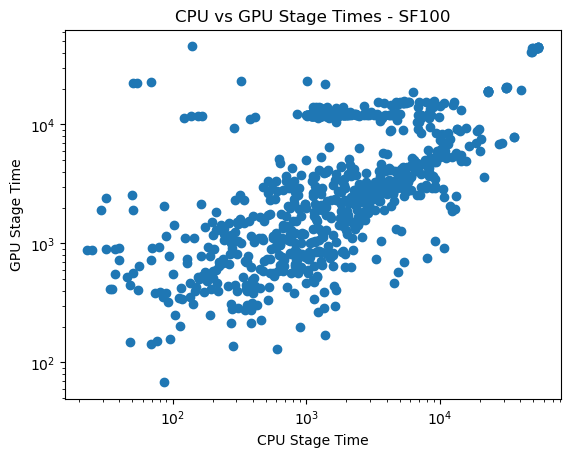

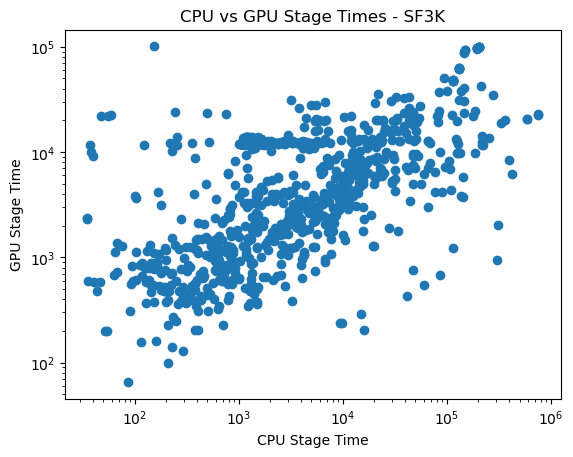

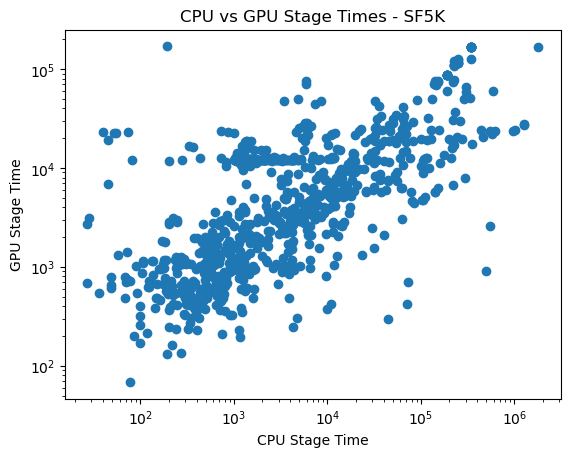

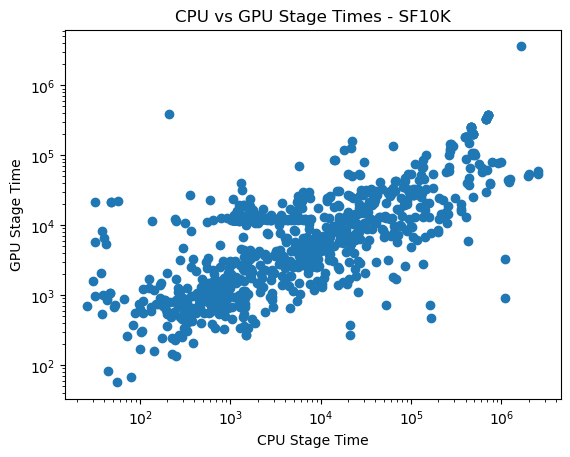

In [15]:
for sf in range(num_scale_factors):
    plt.scatter(cpu_stage_times[sf], gpu_stage_times[sf])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f"CPU vs GPU Stage Times - SF{scale_factors[sf]}")
    plt.xlabel("CPU Stage Time")
    plt.ylabel("GPU Stage Time")
    plt.show()

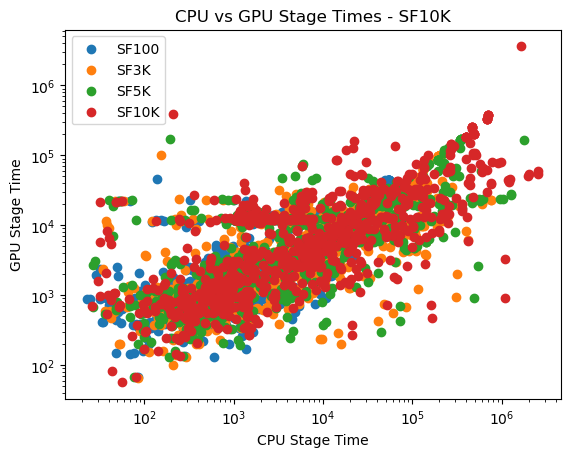

In [16]:
for sf in range(num_scale_factors):
    plt.scatter(cpu_stage_times[sf], gpu_stage_times[sf], label=f"SF{scale_factors[sf]}")
plt.xscale('log')
plt.yscale('log')
plt.title(f"CPU vs GPU Stage Times - SF{scale_factors[sf]}")
plt.xlabel("CPU Stage Time")
plt.ylabel("GPU Stage Time")
plt.legend()
plt.show()